In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
import torch.optim as optim
from cebra_utils import *
import pickle

In [2]:
cebra_model_path = 'models/cebra_model_complete.pt'

data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

label_paths = list(filter(lambda x : x.endswith('.pickle') , iter(os.listdir('.'))))

neural_data_paths.sort()
behavior_data_paths.sort()
dino_paths.sort()
label_paths.sort()

In [6]:
from sklearn.metrics import confusion_matrix
# confusion = confusion_matrix(true_labels, predicted_labels)
# plot the confusion matrix


def plot_confusion_matrix(confusion_matrix, labels, title):
    # Normalize the confusion matrix
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    fig, ax = plt.subplots()
    im = ax.imshow(normalized_matrix, cmap='cividis')

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized', rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{confusion_matrix[i, j]}', ha="center", va="center", color="w")

    # Set labels for the x-axis, y-axis, and title
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)

    # add accuracy to title
    ax.set_title(title + f'\nAccuracy: {accuracy:.2f}')

    # Show the plot
    plt.show()


In [7]:
model_group = torch.load('models/cebra_model_flattened_offset1.pt').model.eval().to('cuda')

In [13]:
name_to_model_id = { 
    '2021_1_8_MV1_run' : 0,
    '2020_11_23_MV1_run' : 1,
    '2020_12_4_MV1_run' : 2,
    '2020_11_2_MV1_run' : 3,
    '2021_1_12_MV1_run' : 4,
    '2020_12_10_MV1_run' : 5,
    '2020_11_9_MV1_run' : 6,
    '2020_11_17_MV1_run' : 7,
}

Generating embeddings
Fitting decoder


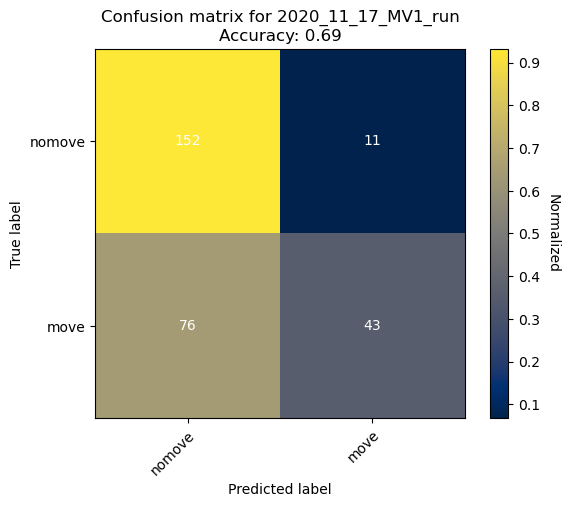

Generating embeddings
Fitting decoder


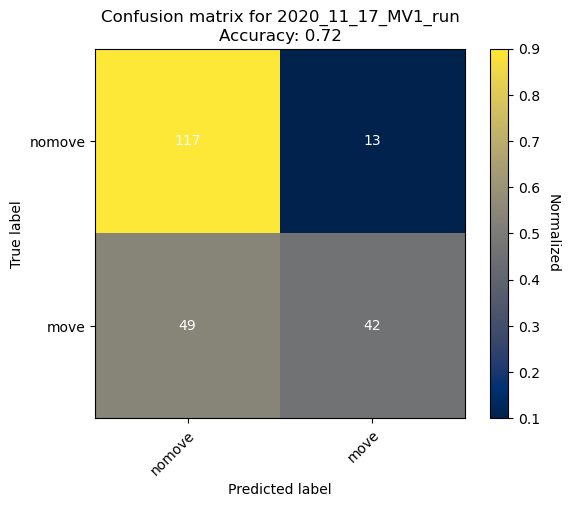

Generating embeddings
Fitting decoder


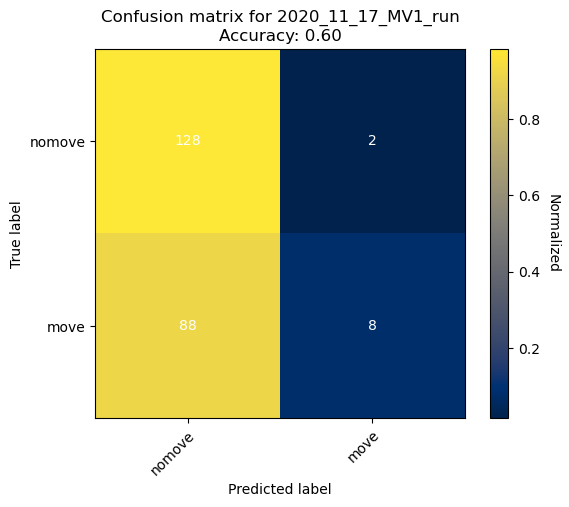

: 

: 

In [14]:
from sklearn.neighbors import NearestNeighbors

con_mat = []

for index in range(len(neural_data_paths)):
    embeddings = []
    name = []
    valid_embeddings = []
    valid_name = []
    labels = []
    valid_labels = []
    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.8)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.8, max = 1)
    # data.extend(temp_data)
    # valid_data.extend(temp_valid_data)
    print('Generating embeddings')
    temp_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)
    for label, data in zip(temp_name, temp_data):
        if label.split('_')[0] == 'move':
            labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))
    for label, data in zip(temp_valid_name, temp_valid_data):
        if label.split('_')[0] == 'move':
            valid_labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            valid_labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))

    labels = np.array(labels)
    valid_labels = np.array(valid_labels)
    decoder = cebra.KNNDecoder(n_neighbors=72, metric='cosine')
    print('Fitting decoder')
    decoder.fit(embeddings, labels)
    pred_labels = decoder.predict(valid_embeddings)
    clip_valid_labels = reshape_frames(np.argmax(valid_labels, axis=1), temp_valid_data)
    clip_pred_labels = reshape_frames(np.argmax(pred_labels, axis=1), temp_valid_data)
    clip_valid_labels = [np.round(np.median(x)) for x in (clip_valid_labels)]
    clip_pred_labels = [np.round(np.median(x)) for x in (clip_pred_labels)]
    confusion = confusion_matrix(clip_valid_labels, clip_pred_labels)
    plot_confusion_matrix(confusion, ['nomove', 'move'], f'Confusion matrix for {neural_data_paths[0].split("/")[-1].split(".")[0]}')
    con_mat.append(confusion)


In [9]:
embeddings = []
valid_embeddings = []
labels = []
valid_label = []
for index in range(len(neural_data_paths)):
    print('Indices: ' +(neural_data_paths[index]) + label_paths[index])
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: x, min = 0.0, max = 0.15)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: x, min = 0.15, max = 0.2)
    with open(label_paths[index], 'rb') as f:
        label_dict = pickle.load(f)
    temp_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (2,3)) for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    labels.extend([np.ones(len(y)) * np.argmax(label_dict[x]) for x, y in zip(temp_name, temp_data)])
    valid_label.extend([np.ones(len(y)) * np.argmax(label_dict[x]) for x, y in zip(temp_valid_name, temp_valid_data)])
labels = np.concatenate(labels)
valid_labels = np.concatenate(valid_label)
decoder = cebra.KNNDecoder(n_neighbors=100, metric='cosine')
decoder.fit(embeddings, labels)
pred_labels = decoder.predict(valid_embeddings)
score = decoder.score(valid_embeddings, valid_labels)
confusion = confusion_matrix(valid_labels, np.round(pred_labels))
plot_confusion_matrix(confusion,  ['Still', 'Sniffing', 'Running', 'Grooming'])
print(score)

Indices: /mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/brain/2020_11_17_MV1_run2020_11_17_MV1_runlabels.pickle


TypeError: 'Offset0Modelv5' object is not subscriptable

In [ ]:
model_group = torch.load('models/cebra_model_complete_30frame.pt').model
embeddings = []
name = []
valid_embeddings = []
valid_name = []
data = []
valid_data = []
index = 1
temp_data, temp_name = import_data(neural_data_paths[index], lambda x: bin_data(x, 30), min = 0.0, max = 0.6)
temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: bin_data(x, 30), min = 0.6, max = 8)
data.append(temp_data)
valid_data.append(temp_valid_data)
temp_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (0,1)) for i, x in enumerate(temp_data)])
temp_valid_embeddings = flatten_data([generate_CEBRA_embeddings(model_group[index], x, i, (0,1)) for i, x in enumerate(temp_valid_data)])
embeddings.extend(temp_embeddings)
valid_embeddings.extend(temp_valid_embeddings)
name.extend(temp_name)
valid_name.extend(temp_valid_name)
decoder = cebra.KNNDecoder(n_neighbors=36, metric='cosine')
labels = np.concatenate([np.ones(len(y)) * (x.split('_')[0] == 'move') for x, y in zip(name, data)])
valid_labels = np.concatenate([np.ones(len(y)) * (x.split('_')[0] == 'move') for x, y in zip(valid_name, valid_data)])
decoder.fit(embeddings, labels)
pred_labels = decoder.predict(valid_embeddings)
score = decoder.score(valid_embeddings, valid_labels)
confusion = confusion_matrix(valid_labels, np.round(pred_labels))
plot_confusion_matrix(confusion, ['move', 'nomove'])
print(score)

RuntimeError: Tensors must have same number of dimensions: got 4 and 5

In [ ]:
((data[0]))